# BCycle all-data Models 

This notebook uses the cleaned data for all trips from the opening of BCycle in 2013 through to the end of 2016. The data provide from BCycle is split into two normalized tables:

## `all_trips_clean.csv`

This is the time-varying trips table, and has the following columns:

* `datetime`: Time the trip began in YYYY-MM-DD HH:MM:SS format. The resolution is 1 minute, i.e. SS is always 00.
* `membership`: Categorical column with memebrship type.
* `bike_id`: Integer ID of the bike used for a trip
* `checkout_id`: ID of the station where the bike was checked out (links to stations table).
* `checkin_id`: ID of the station where the bike was checked in (links to stations table).
* `duration`: The length of the trip in minutes


## `all_stations_clean.csv`

This contains the static station information for all 

* `address`: Station address
* `lat`: Station latitude
* `lon`: Station longitude
* `name`: Station Name
* `station_id`: Station unique identifier (ID), used to link to trips table



## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper functions

Before getting started on the data analysis, let's define a few useful functions we can call to plot data and reproduce the same analysis.

In [115]:
# todo ! Define the style in one place to keep graphs consistent

# plt.style.use('fivethirtyeight')
# # plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Helvetica'
# plt.rcParams['font.monospace'] = 'Consolas'
# plt.rcParams['font.size'] = 10
# plt.rcParams['axes.labelsize'] = 10
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['xtick.labelsize'] = 8
# plt.rcParams['ytick.labelsize'] = 8
# plt.rcParams['legend.fontsize'] = 10
# plt.rcParams['figure.titlesize'] = 12

PLT_DPI = 150


def plot_ts(df, true, pred, title, ax):
    '''Generates one of the subplots to show time series'''
    plot_df = df.resample('1D').sum()
    ax = plot_df.plot(y=[pred, true], ax=ax) # , color='black', style=['--', '-'])
    ax.set_xlabel('', fontdict={'size' : 14})
    ax.set_ylabel('Rentals', fontdict={'size' : 14})
    ax.set_title(title + ' time series', fontdict={'size' : 16}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.legend(['Predicted rentals', 'Actual rentals'], fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   
    

def plot_scatter(true, pred, title, ax):
    '''Plots the results of a validation run on a scatter plot'''
    min_val = result_val_df.min().min() - 10.0
    max_val = result_val_df.max().max() + 20.0

    plt.scatter(x=true, y=pred)
    plt.axis('equal')
    plt.axis([min_val, max_val, min_val, max_val])
    plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='-', linewidth=1)
    
    ax.set_xlabel('Actual rentals', fontdict={'size' : 14})
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.set_ylabel('Predicted rentals', fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 16}) 

    filename = title.lower().replace(' ', '_')

def plot_all_results(df, true, pred, title):
    ''''''
    fig, ax = plt.subplots(1,2,figsize=(20,10), gridspec_kw={'width_ratios':[2,1]})
    plot_ts(df, true, pred, title, ax=ax[0])
    plot_scatter(df[true], df[pred], title, ax[1])
    filename=title.lower().replace(' ', '-').replace(',','')
    plt.savefig(filename, type='png', dpi=PLT_DPI, bbox_inches='tight')
    print('Saved file to {}'.format(filename))
    

# Load station and trip data

The `notebooks/bcycle_all_data_eda` notebook cleans up the raw CSV file from BCycle, and splits it into a stations and trips dataframe. Because of this, the clean CSV files read in below shouldn't need too much processing. The `bcycle_lib` library contains the functions to load and clean the data.

In [116]:
from bcycle_lib.all_utils import load_bcycle_data

print('Loading stations and trips....', end='')
stations_df, trips_df = load_bcycle_data('../input', 'all_stations_clean.csv', 'all_trips_clean.csv', verbose=False)
print('done!')
print('Bike trips loaded from {} to {}'.format(trips_df.index[0], trips_df.index[-1]))

print('\nStations DF info:')
stations_df.info()
print('\nTrips DF info:')
trips_df.info()

Loading stations and trips....done!
Bike trips loaded from 2013-12-21 09:09:00 to 2016-12-31 23:43:02

Stations DF info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 5 columns):
address       67 non-null object
lat           67 non-null float32
lon           67 non-null float32
name          67 non-null object
station_id    67 non-null uint8
dtypes: float32(2), object(2), uint8(1)
memory usage: 1.7+ KB

Trips DF info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548158 entries, 2013-12-21 09:09:00 to 2016-12-31 23:43:02
Data columns (total 5 columns):
membership     548158 non-null category
bike_id        548158 non-null uint16
checkout_id    548158 non-null uint8
checkin_id     548158 non-null uint8
duration       548158 non-null uint16
dtypes: category(1), uint16(2), uint8(2)
memory usage: 7.8 MB


# Load weather data

When we train the models, we'll use weather data to add some extra information for the model to learn from. With a little bit of investigation we can form our own URLs to get data ranges. Here's a typical URL


```
March 8th to September 21st:
https://www.wunderground.com/history/airport/KATT/2013/3/8/CustomHistory.html?dayend=21&monthend=9&yearend=2013&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=

```
From this example we can piece together where each of the day, month, and year fields come for the start and end time ranges. For example 

```
MM/DD/YYYY to MM2/DD2/YYYY

https://www.wunderground.com/history/airport/KATT/<YYYY>/<MM>/<DD>/CustomHistory.html?dayend=<DD2>&monthend=<MM2>&yearend=<YYYY>&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=

```

Let's make a function that takes two dates, and returns a pandas dataframe of the weather between these. The API only returns up to a year at-a-time, so we'll make multiple calls if there are multiple years.

In [117]:
# import requests
# import io

# def weather_url_from_dates(start_date, end_date):
#     '''Creates a URL string to fetch weather data between dates
#     INPUT: start_date - start date for weather
#            end_date - end date for weather
#     RETURNS: string of the URL 
#     '''
#     assert start_date.year == end_date.year, 'Weather requests have to use same year'
    
#     url = 'https://www.wunderground.com/history/airport/KATT/'
#     url += str(start_date.year) + '/' 
#     url += str(start_date.month) + '/'
#     url += str(start_date.day) + '/'
#     url += 'CustomHistory.html?dayend=' + str(end_date.day)
#     url += '&monthend=' + str(end_date.month)
#     url += '&yearend=' + str(end_date.year)
#     url += '&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&format=1'
    
#     return url

# def weather_from_df_dates(df, verbose=False):
#     '''Returns a dictionary of weather dataframes, one per year
#     INPUT: Dataframe with date index
#     RETURNS : Dataframe of corresponding weather information
#     '''
#     yearly_weather = list()
#     unique_years = set(trips_df.index.year)
#     sorted_years = sorted(unique_years, key=int)
    
#     for year in sorted_years:
#         year_df = trips_df[str(year)]
#         start_date = year_df.index[0]
#         end_date = year_df.index[-1]
#         year_url = weather_url_from_dates(start_date, end_date)
#         if verbose:
#             print('Year {}: start date {}, end date {}'.format(year, start_date, end_date))
# #             print('URL: {}'.format(year_url))

#         if verbose: print('Fetching CSV data ... ', end='')
#         req = requests.get(year_url).content
#         req_df = pd.read_csv(io.StringIO(req.decode('utf-8')))
#         yearly_weather.append(req_df)
#         if verbose: print('done')
            
#     combined_df = pd.concat(yearly_weather)
#     return combined_df

# weather_df = weather_from_df_dates(trips_df, verbose=True)
# print('weather_df shape: {}'.format(weather_df.shape))

# Cleaning weather data

There are some missing values in the weather data. For numeric ones like the Dew Point and Humidity, we'll forward-fill the NA values. For `Events`, a missing value means there wasn't an event on that day, so we don't want to forward fill and add events that didn't happen on that day.

In [118]:
# from bcycle_lib.all_utils import clean_weather
# # Let's check the data for missing values, and forward-fill
# # print('Initial Weather missing value counts:')
# # print(weather_df.isnull().sum(axis=0))

# for col in weather_df.columns:
#     if 'Events' not in col:
#         weather_df[col] = weather_df[col].fillna(method='pad')

# print('\nAfter forward-filling NA values (apart from Events):')
# print(weather_df.isnull().sum(axis=0))

### Save weather out to CSV

For repeatability we can save out the weather data we just downloaded to a CSV file. First of all we need to clean up the columns, and then we can write it out.

In [119]:
# from bcycle_lib.all_utils import clean_weather

# weather_df = clean_weather(weather_df)
# weather_df.to_csv('../input/all_weather.csv')

In [120]:
from bcycle_lib.all_utils import clean_weather

weather_df = pd.read_csv('../input/all_weather.csv')
weather_df = weather_df.set_index('date')
weather_df.head()

,max_temp,min_temp,max_humidity,min_humidity,max_pressure,min_pressure,max_wind,min_wind,max_gust,precipitation,cloud_pct,thunderstorm,snow,rain,fog
date,,,,,,,,,,,,,,,
2013-12-21,74,45,93,57,29.86,29.59,20,4,31,0.46,75.0,1,0,1,0
2013-12-22,56,39,93,43,30.41,29.87,16,6,25,0.00,25.0,0,0,0,0
2013-12-23,58,32,76,27,30.56,30.41,8,3,12,0.00,0.0,0,0,0,0
2013-12-24,61,31,89,22,30.56,30.30,12,4,20,0.00,0.0,0,0,0,0
2013-12-25,58,41,86,56,30.41,30.27,10,2,16,0.01,87.5,0,0,0,0


# Time-based linear model

Let's kick off by creating a linear model based on time features.

In [121]:
from bcycle_lib.all_utils import add_time_features

TRAIN_START = '2014-01-01'
TRAIN_END = '2015-12-31'
VAL_START = '2016-01-01'
VAL_END = '2016-12-31'

hourly_trips_df = trips_df.resample('1H').size().to_frame(name='count')
hourly_trips_df = add_time_features(hourly_trips_df)
train_df = hourly_trips_df[TRAIN_START:TRAIN_END].copy()
val_df = hourly_trips_df[VAL_START:VAL_END].copy()

n_train = train_df.shape[0]
n_val = val_df.shape[0]
n_total = n_train + n_val
n_train_pct = (n_train / n_total) * 100.0
n_val_pct = (n_val / n_total) * 100.0

print('\nTraining data first and last row:\n{}\n{}'.format(train_df.index[0], train_df.index[-1]))
print('\nValidation data first and last row:\n{}\n{}\n'.format(val_df.index[0], val_df.index[-1]))

print('Train data shape: {}, {:.2f}% of rows'.format(train_df.shape, n_train_pct))
print('Validation data shape: {}, {:.2f}% of rows'.format(val_df.shape, n_val_pct))

train_df.head()


Training data first and last row:
2014-01-01 00:00:00
2015-12-31 23:00:00

Validation data first and last row:
2016-01-01 00:00:00
2016-12-31 23:00:00

Train data shape: (17520, 2), 66.61% of rows
Validation data shape: (8784, 2), 33.39% of rows


,count,day-hour
datetime,,
2014-01-01 00:00:00,4,2-0
2014-01-01 01:00:00,0,2-1
2014-01-01 02:00:00,5,2-2
2014-01-01 03:00:00,3,2-3
2014-01-01 04:00:00,0,2-4


# Visualizing hourly rentals

Now we can visualize the training and validation rental data separately. To keep the graphs clear, we'll resample according to the length of data we're dealing with. The training data is from 2014, 2015, and the first half of 2016. The validation data is from the second half of 2016.

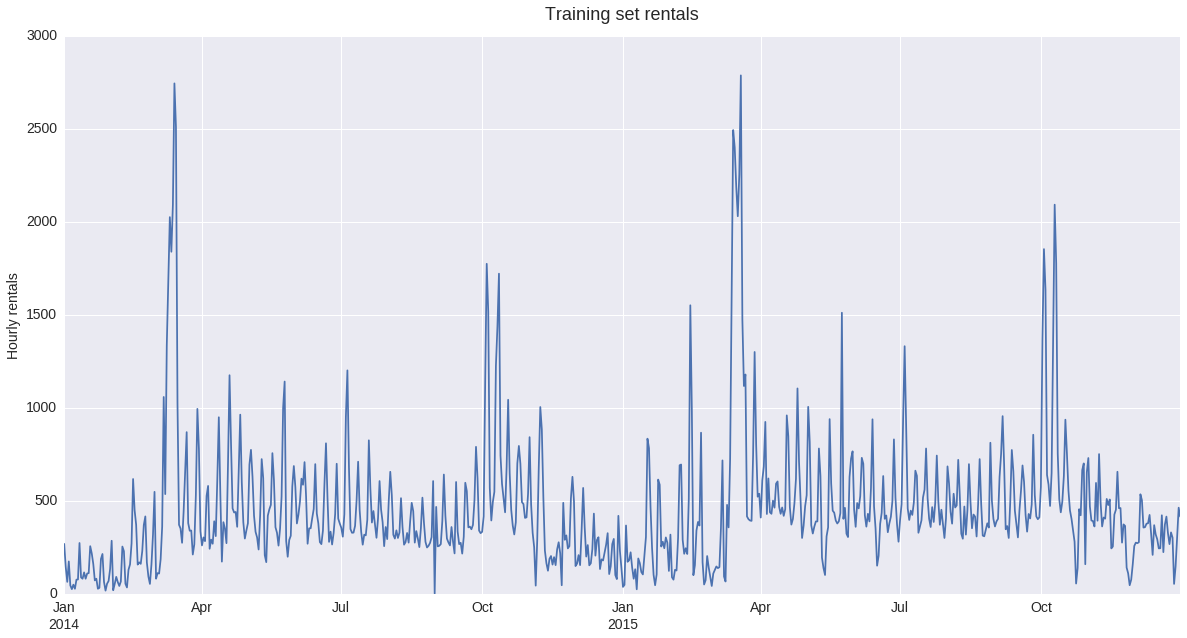

In [122]:
from bcycle_lib.all_utils import plot_lines

plot_df = train_df.resample('1D').sum()['count']

plot_lines(plot_df, plt.subplots(1,1,figsize=(20,10)), 
                                 title='Training set rentals', 
                                 xlabel='', ylabel='Hourly rentals')


The graph shows a single approximately week-long spike in March (during SXSW) of 2750 - 2250 trips. There are also  two sharp peaks a week apart in October (during ACL) of 1750-2000 daily trips. 

After these peaks, there are other days with between 1000 and 1500 trips. There's one in mid-Feb, one towards the end of April, one at the end of May, and another at the start of July. These most likely correspond to national holidays. 

For these special cases, we'll need to add in extra dummy variables to help models work out why the amount of trips suddenly peaks.

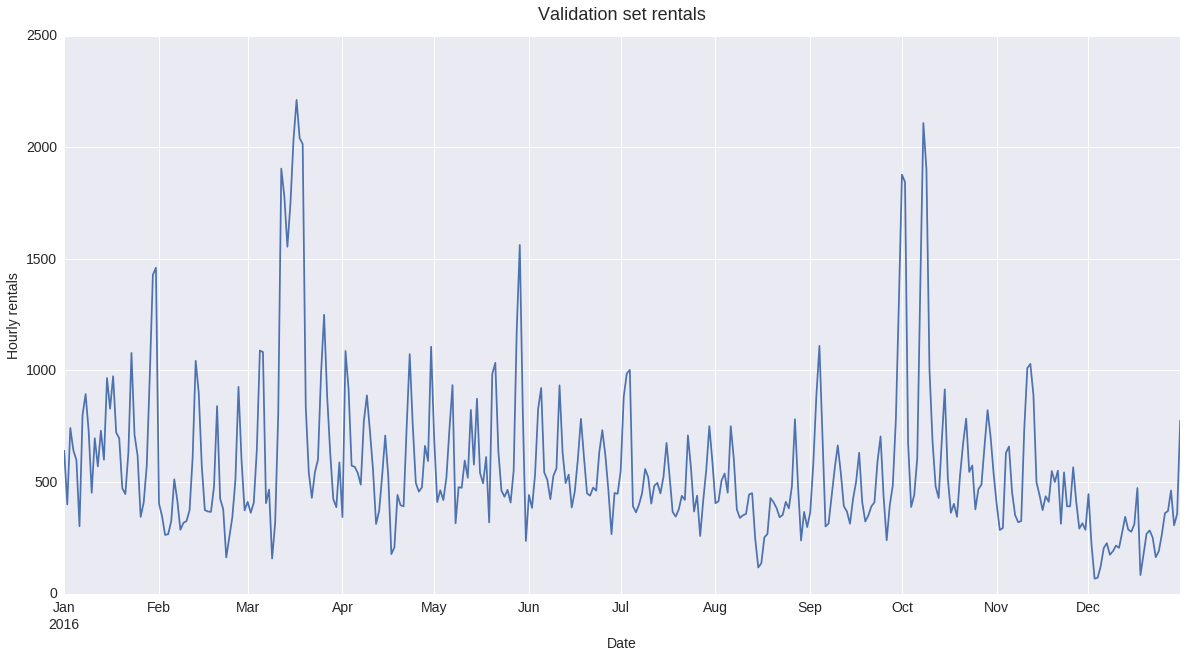

In [123]:
# Let's plot the validation set
plot_df = val_df.resample('1D').sum()['count']

plot_lines(plot_df, plt.subplots(1,1,figsize=(20,10)), 
                                 title='Validation set rentals', 
                                 xlabel='Date', ylabel='Hourly rentals')

The 6-month period of the validation data allows us to see multiple levels of periodicity in the data. The shortest is the daily period. The weekly period is also visible, with most weeks ending in higher levels of trips on Friday, Saturday, and Sunday. 

There are also some special events which are one-off. The spike at the start of September is probably due to the Labor Day holiday, and the one at the end of November is likely Thanksgiving. The two largest peaks are the first two weekends in October, and these correspond to ACL.

# Distributions in training and validation datasets

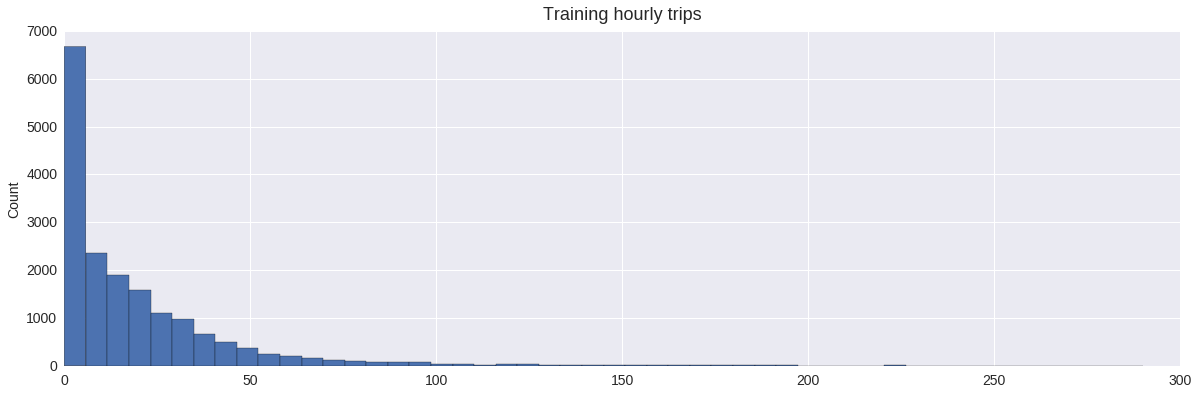

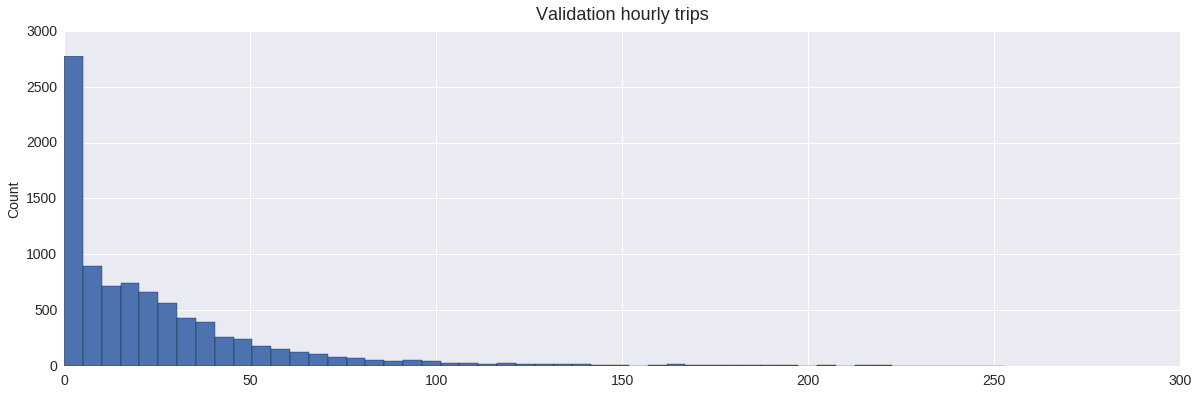

In [124]:
from bcycle_lib.all_utils import plot_hist
SIZE=(20,6)

plot_hist(train_df['count'], bins=50, size=SIZE, title='Training hourly trips', xlabel='', ylabel='Count')
plot_hist(val_df['count'], bins=50, size=SIZE, title='Validation hourly trips', xlabel='', ylabel='Count')

# Baseline linear model

Now we have inspected some of the data, let's create a baseline linear model using time features.

In [125]:
# First create a daily rentals dataframe, split it into training and validation
from bcycle_lib.all_utils import add_time_features

train_df = add_time_features(train_df)
val_df = add_time_features(val_df)

print('Training data shape: {}'.format(train_df.shape))
print('Validation data shape: {}'.format(val_df.shape))

Training data shape: (17520, 2)
Validation data shape: (8784, 2)


In [126]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_df[['day-hour', 'count']], 
                                           target_col='count', 
                                           ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_df[['day-hour', 'count']], 
                                     target_col='count', 
                                     ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (17520, 168), y_train shape: (17520,)
X_val shape: (8784, 168), y_val shape: (8784,)


Hour-of-day baseline RMSE - Train: 20.40, Val: 21.27
Saved file to hour-of-day-baseline


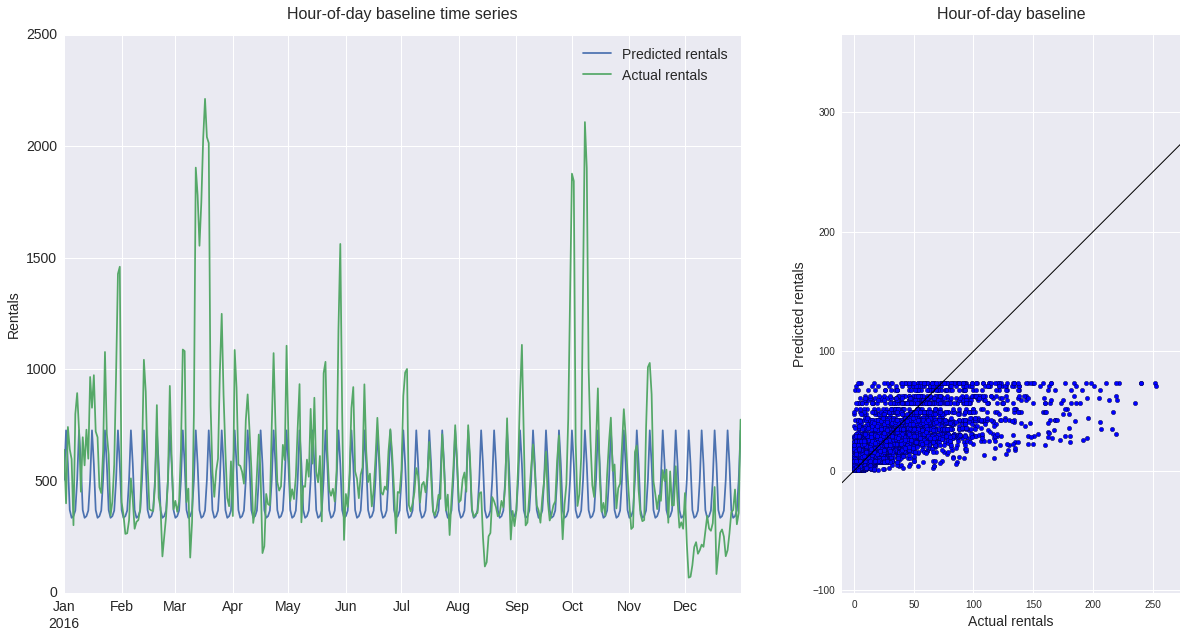

In [127]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from bcycle_lib.all_utils import df_from_results, plot_results, plot_val

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores_df = pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, index=['linreg_time'])

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                 val_df.index, y_val, y_val_pred)

print('Hour-of-day baseline RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day baseline')

This is not a bad baseline model. Strangely, it gets a worse RMSE on the Training dataset than the validation dataset. This is probably because the data in 2014 is markedly lower than in 2015, and the validation set is somewhere in between. This implies I need to add some lagging indicators, as each hourly value is closely correlated with the ones that came before.

# Linear model with holiday and special events

As we saw when inspecting the data, there are quite a few peaks due to special events, and national holidays. Let's add in some dummy variables, so the model factors these into the result.

### Holidays

We'll create a set of indicator variables for each of the holidays, as well as the dates around them. For example if a holiday is on a Monday, we'll add the Saturday and Sunday before that day. Also on Thanksgiving (which is on a Thursday) we'll add in Fri, Sat, and Sun that week.

In [128]:
# Create a list of national holidays, with their observed dates days around them
holidays = {'hol_new_year' : ('2014-01-01', '2015-01-01', '2016-01-01'),
            'hol_mlk' : ('2014-01-18', '2014-01-19','2014-01-20',
                         '2015-01-17', '2015-01-18','2015-01-19',
                         '2016-01-16', '2016-01-17','2016-01-18'),
            'hol_presidents' : ('2014-02-15', '2014-02-16', '2014-02-17',
                                '2015-02-14', '2015-02-15', '2015-02-16',
                                '2016-02-13', '2016-02-14', '2016-02-15'),
            'hol_memorial' : ('2014-05-24', '2014-05-25', '2014-05-26',
                              '2015-05-23', '2015-05-24', '2015-05-25',
                              '2016-05-28', '2016-05-29', '2016-05-30'),
            'hol_independence' : ('2014-07-04', '2014-07-05', '2014-07-06',
                                  '2015-07-03', '2015-07-04', '2015-07-05',
                                  '2016-07-02', '2016-07-03', '2016-07-04'),
            'hol_labor' : ('2014-08-30', '2014-08-31', '2014-09-01',
                           '2015-09-05', '2015-09-06', '2015-09-07',
                           '2016-09-03', '2016-09-04', '2016-09-05'),
            'hol_columbus' : ('2014-10-11', '2014-10-12', '2014-10-13',
                              '2015-10-10', '2015-10-11', '2015-10-12',
                              '2016-10-08', '2016-10-09', '2016-10-10'),
            'hol_veterans' : ('2014-11-11', '2015-11-11', '2016-11-11'),
            'hol_thanksgiving' : ('2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
                                  '2015-11-26', '2015-11-27', '2015-11-28', '2015-11-29',
                                  '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27'),
            'hol_christmas' : ('2014-12-25', '2014-12-26', '2014-12-27', '2014-12-28',
                               '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
                               '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27')
           }


def add_date_indicator(df, col, dates):
    '''Adds a new indicator column with given dates set to 1
    INPUT: df - Dataframe
           col - New column name
           dates - Tuple of dates to set indicator to 1
    RETURNS: Dataframe with new column
    '''
    df.loc[:,col] = 0
    for date in dates:
        if date in df.index:
            df.loc[date, col] = 1
            
    df[col] = df[col].astype(np.uint8)
    return df

for key, value in holidays.items():
    train_df = add_date_indicator(train_df, key, value)
    val_df = add_date_indicator(val_df, key, value)

### Events

Now we can add in the special events that generate a huge spike in traffic in March and October. This helps the model work out it's not just a normal Saturday . Sunday.

In [129]:
# Create a list of national holidays, with their observed dates days around them
import itertools

def day_list(start_date, end_date):
    '''Creates list of dates between `start_date` and `end_date`'''
    date_range = pd.date_range(start_date, end_date)
    dates = [d.strftime('%Y-%m-%d') for d in date_range]
    return dates

sxsw2014 = day_list('2014-03-07', '2014-03-16')
sxsw2015 = day_list('2015-03-13', '2015-03-22')
sxsw2016 = day_list('2016-03-11', '2016-03-20')
sxsw = list(itertools.chain.from_iterable([sxsw2014, sxsw2015, sxsw2016]))

acl2014_wk1 = day_list('2014-10-03', '2014-10-05')
acl2014_wk2 = day_list('2014-10-10', '2014-10-12')
acl2015_wk1 = day_list('2015-10-02', '2015-10-04')
acl2015_wk2 = day_list('2015-10-09', '2015-10-11')
acl2016_wk1 = day_list('2016-09-30', '2016-10-02')
acl2016_wk2 = day_list('2016-10-07', '2016-10-09')
acl = list(itertools.chain.from_iterable([acl2014_wk1, acl2014_wk2, 
                                          acl2015_wk1, acl2015_wk2, 
                                          acl2016_wk1, acl2016_wk2]))


events = {'event_sxsw' : sxsw,
          'event_acl'  : acl
         }

for key, value in events.items():
    train_df = add_date_indicator(train_df, key, value)
    val_df = add_date_indicator(val_df, key, value)


In [130]:
# Check they were all added here 1
train_df.describe()
# train_df.head()

# train_df[train_df['event_sxsw'] == 1]

,count,hol_memorial,hol_mlk,hol_columbus,hol_new_year,hol_presidents,hol_thanksgiving,hol_independence,hol_veterans,hol_christmas,hol_labor,event_sxsw,event_acl
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,19.174087,0.008219,0.008219,0.008219,0.002740,0.008219,0.010959,0.008219,0.002740,0.010959,0.008219,0.027397,0.016438
std,26.543743,0.090289,0.090289,0.090289,0.052272,0.090289,0.104113,0.090289,0.052272,0.104113,0.090289,0.163243,0.127158
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,290.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Training model with new time features (holidays and special events)

Now we've manually annotated all the days with special events and hoildays, let's see if that improves the model training results on the validation set.

In [131]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_df,
                                    target_col='count', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_df,
                                target_col='count', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (17520, 180), y_train shape: (17520,)
X_val shape: (8784, 180), y_val shape: (8784,)


Hour-of-day and events RMSE - Train: 17.08, Val: 18.91
Saved file to hour-of-day-with-events


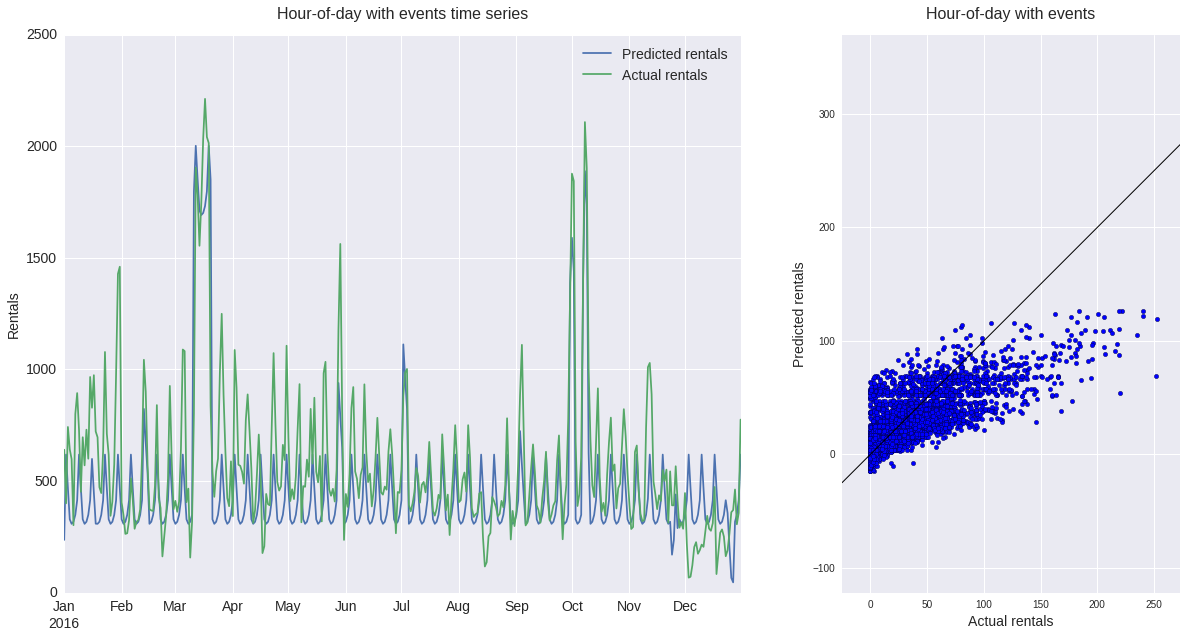

In [132]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_events' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
                                              index=['linreg_time_events']))

print('Hour-of-day and events RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day with events')

# Linear model with holidays, events, and lagged features

Now we have one-off special events and holidays added to the model to account for point increases over a day or two, we can add lagged time features to model longer-term changes in the amount of rentals. Let's 

In [133]:
def add_lag_time_features(df, col):
    """Adds time-lagged features to improve prediction
    INPUT: df - Dataframe with date index
           col - column in dataframe used to calculate lags
    RETURNS: Dataframe with extra lag features
    """
#     df[col + '_lag_1H'] = df[col].shift(1).fillna(method='backfill')
    df[col + '_lag_1D'] = df[col].shift(24 * 1).fillna(method='backfill')
    df[col + '_lag_2D'] = df[col].shift(24 * 2).fillna(method='backfill')
    df[col + '_lag_3D'] = df[col].shift(24 * 3).fillna(method='backfill')
    df[col + '_lag_4D'] = df[col].shift(24 * 4).fillna(method='backfill')
    df[col + '_lag_5D'] = df[col].shift(24 * 5).fillna(method='backfill')
    df[col + '_lag_6D'] = df[col].shift(24 * 6).fillna(method='backfill')
    df[col + '_lag_1W'] = df[col].shift(24 * 7).fillna(method='backfill')
    return df

def add_win_time_features(df, col):
    """Adds rolling window features to improve prediction
    INPUT: df - Dataframe with date index
           col - column in dataframe used to calculate lags
    RETURNS: Dataframe with extra window features
    """
    df[col + '_win_1D'] = df[col].rolling(window=24, win_type='blackman').mean().fillna(method='backfill')
    df[col + '_win_1W'] = df[col].rolling(window=24*7, win_type='blackman').mean().fillna(method='backfill')
    return df

def add_median_time_features(df, col):
    """Adds median bike rental values to correct for longer term changes
    """
    df[col + '_med_1D'] = df[col].shift(24).resample('1D').median()
    df[col + '_med_1D'] = df[col + '_med_1D'].fillna(method='ffill').fillna(0)
    df[col + '_med_1W'] = df[col].shift(24*7).resample('1W').median()
    df[col + '_med_1W'] = df[col + '_med_1W'].fillna(method='ffill').fillna(0)
    df[col + '_med_1M'] = df[col].shift(24*30).resample('1M').median()
    df[col + '_med_1M'] = df[col + '_med_1M'].fillna(method='ffill').fillna(0)

    return df


train_df = add_lag_time_features(train_df, 'count')
val_df   = add_lag_time_features(val_df  , 'count')

train_df = add_win_time_features(train_df, 'count')
val_df   = add_win_time_features(val_df  , 'count')

train_df = add_median_time_features(train_df, 'count')
val_df   = add_median_time_features(val_df  , 'count')

### Plotting lag and window features

Now we've added the window and lag features, let's see how they look compared with the actual values that were used to calculate them.

In [134]:
# # Lag features

# plot_df = train_df['2015-01-01':'2015-01-31']
# plot_lines(plot_df[['count', 'count_win_1D']], plt.subplots(1,1,figsize=(20,10)), title='', xlabel='', ylabel='')

In [135]:
# train_df.loc['2014-01-01':'2014-01-31', ('count', 'count_weekly_median')].plot.line(figsize=(20,10))

### Evaluating the model

In [136]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_df,
                                    target_col='count', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_df,
                                target_col='count', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (17520, 192), y_train shape: (17520,)
X_val shape: (8784, 192), y_val shape: (8784,)


In [137]:
scores_df

,train_rmse,val_rmse
linreg_time,20.399565,21.271591
linreg_time_events,17.083082,18.906977


Hour-of-day with events and lags RMSE - Train: 14.09, Val: 14.99
Saved file to hour-of-day-with-events-and-lags


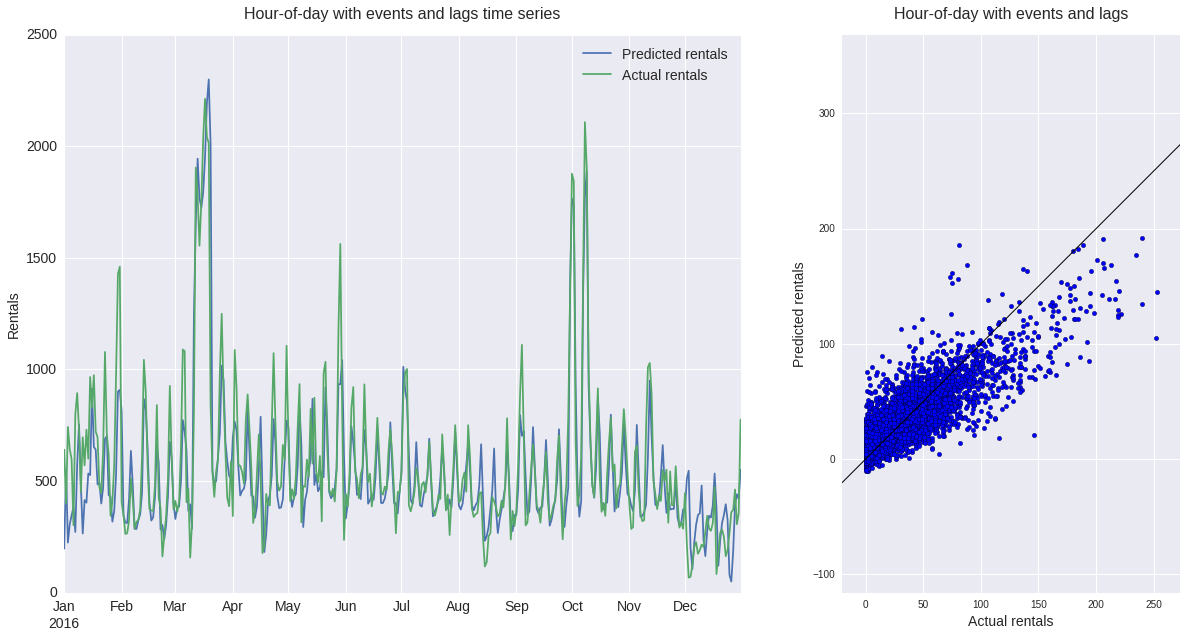

In [138]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_events_lags' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
                                              index=['linreg_time_events_lags']))

print('Hour-of-day with events and lags RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day with events and lags')

In [139]:
# train_weather_df['precipitation'].plot.hist(bins=40, figsize=(20,10))

# Weather-based models

Now we've added in all the time-based features that 

In [140]:
# # Merge the training and validation datasets with the weather dataframe

def merge_daily_weather(df, weather_df):
    '''Merges the dataframes using the date in their indexes
    INPUT: df - Dataframe to be merged with date-based index
           weather_df - Dataframe to be merged with date-based index
    RETURNS: merged dataframe
    '''    

    # Extract the date only from df's index
    df = df.reset_index()
    df['date'] = df['datetime'].dt.date.astype('datetime64')
#     df = df.set_index('datetime')
    
    # Extract the date field to join on
    weather_df = weather_df.reset_index()
    weather_df['date'] = weather_df['date'].astype('datetime64')
    
    # Merge with the weather information using the date
    merged_df = pd.merge(df, weather_df, on='date', how='left')
    merged_df.index = df.index
    merged_df = merged_df.set_index('datetime', drop=True)
    merged_df = merged_df.drop('date', axis=1)
    assert df.shape[0] == merged_df.shape[0], "Error - row mismatch after merge"
    
    return merged_df

GOOD_COLS = ['max_temp', 'min_temp', 'max_gust', 'precipitation', 
        'cloud_pct', 'thunderstorm']


train_weather_df = merge_daily_weather(train_df, weather_df[GOOD_COLS])
val_weather_df = merge_daily_weather(val_df, weather_df[GOOD_COLS])

train_weather_df.head()

,count,day-hour,hol_memorial,hol_mlk,hol_columbus,hol_new_year,hol_presidents,hol_thanksgiving,hol_independence,hol_veterans,...,count_win_1W,count_med_1D,count_med_1W,count_med_1M,max_temp,min_temp,max_gust,precipitation,cloud_pct,thunderstorm
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,4,2-0,0,0,0,1,0,0,0,0,...,4.329015,0.0,0.0,0.0,69,39,22,0.0,37.5,0
2014-01-01 01:00:00,0,2-1,0,0,0,1,0,0,0,0,...,4.329015,0.0,0.0,0.0,69,39,22,0.0,37.5,0
2014-01-01 02:00:00,5,2-2,0,0,0,1,0,0,0,0,...,4.329015,0.0,0.0,0.0,69,39,22,0.0,37.5,0
2014-01-01 03:00:00,3,2-3,0,0,0,1,0,0,0,0,...,4.329015,0.0,0.0,0.0,69,39,22,0.0,37.5,0
2014-01-01 04:00:00,0,2-4,0,0,0,1,0,0,0,0,...,4.329015,0.0,0.0,0.0,69,39,22,0.0,37.5,0


In [141]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_weather_df,
                                    target_col='count', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_weather_df,
                                target_col='count', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (17520, 198), y_train shape: (17520,)
X_val shape: (8784, 198), y_val shape: (8784,)


Hour-of-day, events, lags, and weather RMSE - Train: 13.79, Val: 14.81
Saved file to hour-of-day-with-events-lags-and-weather


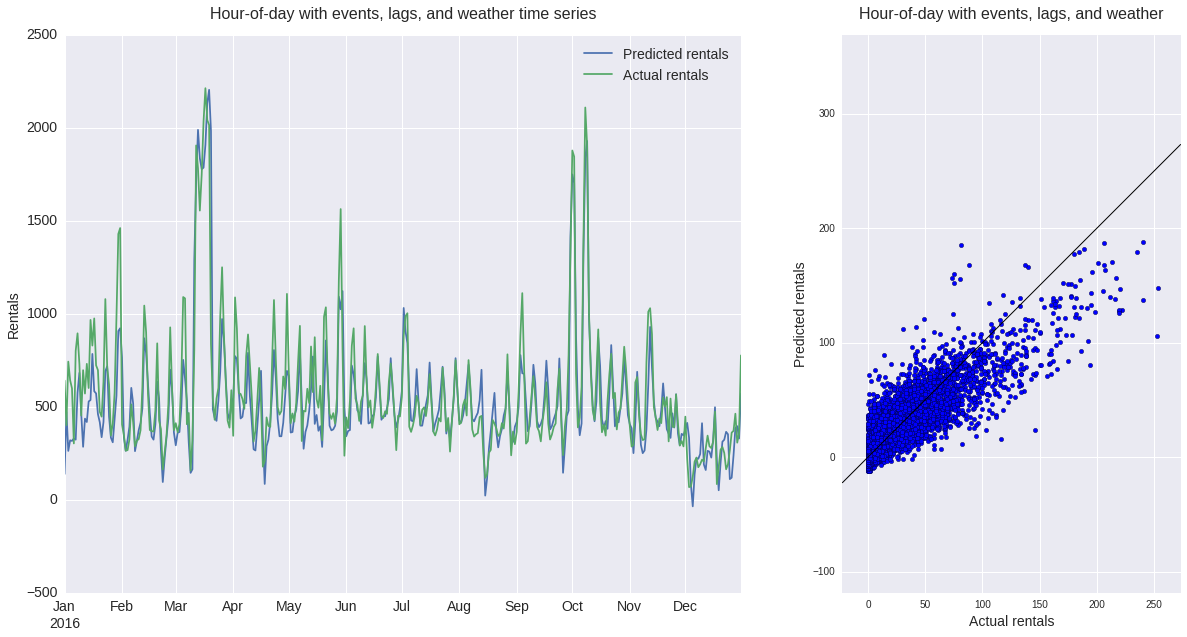

In [142]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_events_lags_weather' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
                                              index=['linreg_time_events_lags_weather']))

print('Hour-of-day, events, lags, and weather RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day with events, lags, and weather')

# Investigating training vs validation performance

Saved file to training-hour-of-day-with-events-lags-and-weather


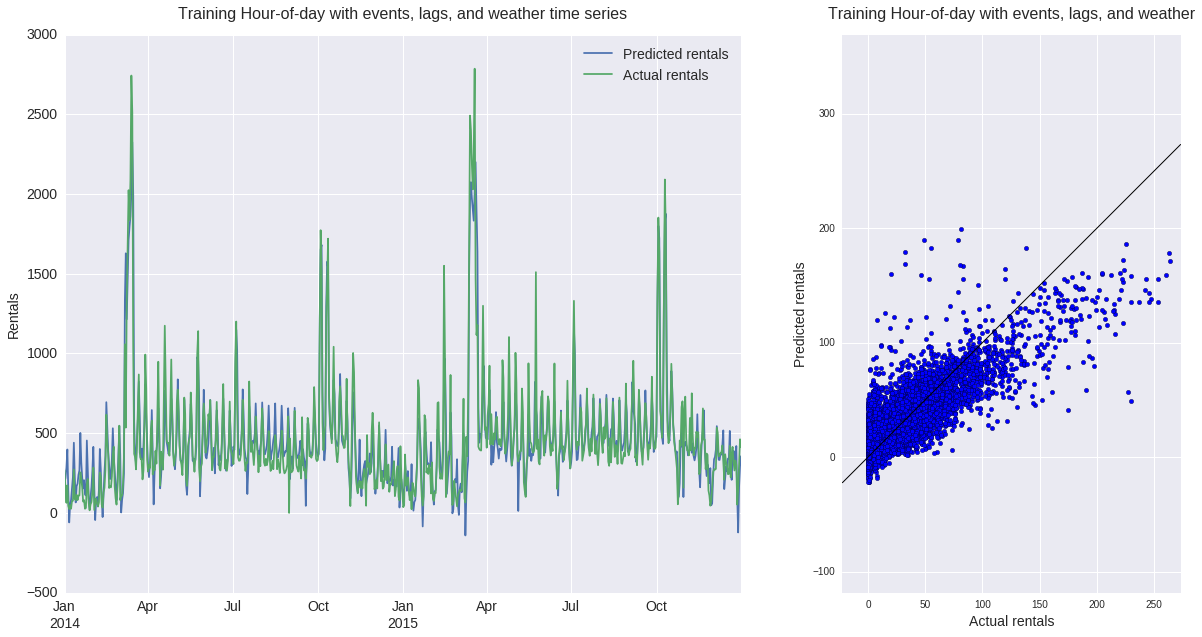

In [143]:
plot_all_results(result_train_df, 'true', 'pred', 'Training Hour-of-day with events, lags, and weather')

In [144]:
trips_df.head()

,membership,bike_id,checkout_id,checkin_id,duration
datetime,,,,,
2013-12-21 09:09:00,triannual,966,2,66,5
2013-12-21 09:11:00,year,36,3,4,5
2013-12-21 10:09:00,day,101,66,9,19
2013-12-21 13:48:00,day,252,4,4,4
2013-12-21 13:51:00,day,287,7,2,12


# Feature engineering summary

,train_rmse,val_rmse
linreg_time,20.40,21.27
linreg_time_events,17.08,18.91
linreg_time_events_lags,14.09,14.99
linreg_time_events_lags_weather,13.79,14.81


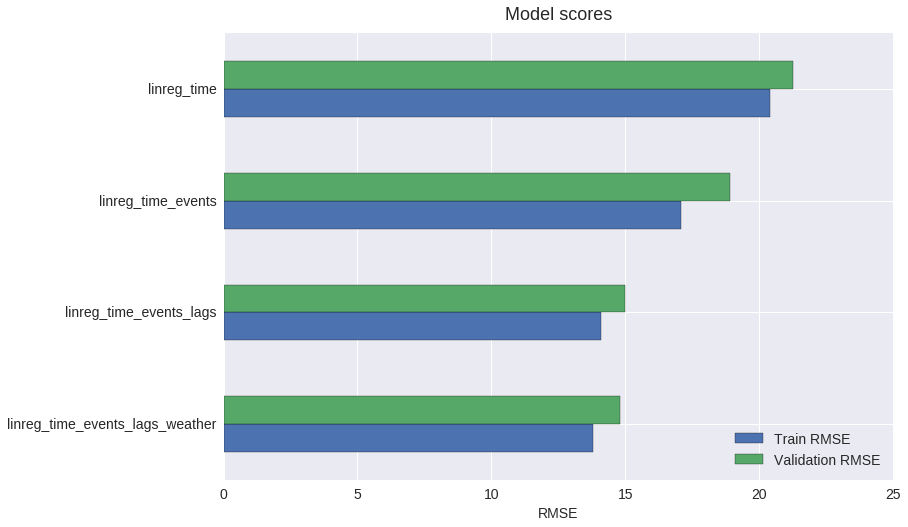

In [145]:
from bcycle_lib.all_utils import plot_scores
plot_scores(scores_df, 'Model scores', 'val_rmse')
plt.savefig('scores.png', dpi=PLT_DPI, bbox_inches='tight')

scores_df.round(2)

In [151]:
from sklearn.preprocessing import StandardScaler

def model_eval(model, train_df, val_df, verbose=False):
    '''Evaluates model using training and validation sets'''
    X_train, y_train, _ = reg_x_y_split(train_df, target_col='count',  ohe_cols=['day-hour'], verbose=verbose)
    X_val, y_val, _ = reg_x_y_split(val_df, target_col='count',  ohe_cols=['day-hour'], verbose=verbose)

    if verbose:
        print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
        print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
    
    reg = model
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_val_pred = reg.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                             val_df.index, y_val, y_val_pred)

    out = {'train_rmse' : train_rmse, 
           'val_rmse' : val_rmse,
           'result_train' : result_train_df,
           'result_val' : result_val_df}
    
    print('RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

    return out

model_result = model_eval(Ridge(), train_weather_df, val_weather_df,
               verbose=False)

#     plot_all_results(result_val_df, 'true', 'pred', 'Hour-of-day with events, lags, and weather')


RMSE - Train: 13.79, Val: 14.81


# Other models?

In [149]:
# Ridge regression
from sklearn.linear_model import Ridge
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, KFold

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

cv_results = dict()

for alpha in (0.001, 0.01, 0.1, 1, 10, 100):
    ridge = Ridge(alpha=alpha)
    model_result = model_eval(ridge, train_weather_df, val_weather_df, verbose=False)
    cv_results[alpha] = model_result


best_val_rmse = 100    
for key, value in cv_results.items():
    if (cv_results[key]['val_rmse']) < best_val_rmse:
        best_val_rmse = cv_results[key]['val_rmse']
    print('{:>8} - Train RMSE: {:.2f}, Val RMSE: {:.2f}'.format(key,
                                                     cv_results[key]['train_rmse'], 
                                                     cv_results[key]['val_rmse']))
print('\nBest validation RMSE is {:.2f}'.format(best_val_rmse))

RMSE - Train: 13.79, Val: 14.81
RMSE - Train: 13.79, Val: 14.81
RMSE - Train: 13.79, Val: 14.81
RMSE - Train: 13.79, Val: 14.81
RMSE - Train: 13.79, Val: 14.81
RMSE - Train: 13.79, Val: 14.80
     0.1 - Train RMSE: 13.79, Val RMSE: 14.81
       1 - Train RMSE: 13.79, Val RMSE: 14.81
     100 - Train RMSE: 13.79, Val RMSE: 14.80
      10 - Train RMSE: 13.79, Val RMSE: 14.81
    0.01 - Train RMSE: 13.79, Val RMSE: 14.81
   0.001 - Train RMSE: 13.79, Val RMSE: 14.81

Best validation RMSE is 14.80


In [150]:
# Lasso
from sklearn.linear_model import Lasso
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, KFold


param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

cv_results = dict()

for alpha in (0.001, 0.01, 0.1, 1, 10, 100):
    ridge = Lasso(alpha=alpha)
    model_result = model_eval(ridge, train_weather_df, val_weather_df, verbose=False)
    cv_results[alpha] = model_result


best_val_rmse = 100    
for key, value in cv_results.items():
    if (cv_results[key]['val_rmse']) < best_val_rmse:
        best_val_rmse = cv_results[key]['val_rmse']
    print('{:>8} - Train RMSE: {:.2f}, Val RMSE: {:.2f}'.format(key,
                                                     cv_results[key]['train_rmse'], 
                                                     cv_results[key]['val_rmse']))
print('\nBest validation RMSE is {:.2f}'.format(best_val_rmse))

/home/tim/anaconda3/envs/ds450_env/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE - Train: 13.79, Val: 14.81
RMSE - Train: 13.79, Val: 14.81
RMSE - Train: 13.88, Val: 14.87
RMSE - Train: 15.26, Val: 16.00
RMSE - Train: 20.33, Val: 22.40
RMSE - Train: 26.54, Val: 29.78
     0.1 - Train RMSE: 13.88, Val RMSE: 14.87
       1 - Train RMSE: 15.26, Val RMSE: 16.00
     100 - Train RMSE: 26.54, Val RMSE: 29.78
      10 - Train RMSE: 20.33, Val RMSE: 22.40
    0.01 - Train RMSE: 13.79, Val RMSE: 14.81
   0.001 - Train RMSE: 13.79, Val RMSE: 14.81

Best validation RMSE is 14.81


In [66]:
# Adaboost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, KFold

param_grid = {'n_estimators': [10, 50, 100, 400],
              'loss' : ['linear', 'square', 'exponential']}

cv_results = dict()

best_val_train = 100  
best_val_rmse = 100  
best_model = None

for n in [10, 50, 100, 400]:
    for loss in ['linear', 'square', 'exponential']:
        model = AdaBoostRegressor(n_estimators=n, loss=loss)
        model_result = model_eval(model, train_weather_df, val_weather_df, verbose=False)
        cv_results[(n, loss)] = model_result
        
        if model_result['val_rmse'] < best_val_rmse:
            best_result = model_result
            best_model = model

print('\nBest results: Train RMSE: {.2f}, Val RMSE is {:.2f}'.format(best_val_rmse))



RMSE - Train: 15.95, Val: 18.62
RMSE - Train: 16.17, Val: 19.18
RMSE - Train: 15.90, Val: 18.09
RMSE - Train: 26.42, Val: 26.33
RMSE - Train: 22.48, Val: 23.74
RMSE - Train: 30.85, Val: 29.23
RMSE - Train: 28.30, Val: 27.25
RMSE - Train: 24.15, Val: 24.85
RMSE - Train: 33.06, Val: 31.35
RMSE - Train: 30.61, Val: 29.34
RMSE - Train: 25.89, Val: 25.70
RMSE - Train: 38.55, Val: 36.41

Best validation RMSE is 18.09


In [67]:
print(best_model)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='exponential',
         n_estimators=10, random_state=None)


In [68]:
# Random Forests
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, KFold

num_feats = X_train.shape[1]
param_grid = {'n_estimators': [10, 50, 100, 400],
              'max_features' : ['auto', 'sqrt', 'log2'],
              'learning_rate' : [0.5, 0.75, 1.0]
              }

cv_results = dict()

best_val_rmse = 100  
best_model = None

for n_estimators in [10, 50, 100, 400, 800]:
    for max_features in ['auto', 'sqrt', 'log2']:
        for learning_rate in [0.5, 0.75, 1.0]:
            print('N = {}, max_features = {}, learning_rate = {}'.format(n_estimators, max_features, learning_rate))
            model = GradientBoostingRegressor(n_estimators=n, max_features=max_features, learning_rate=learning_rate)
            model_result = model_eval(model, train_weather_df, val_weather_df, verbose=False)
            cv_results[(n, loss)] = model_result

            if model_result['val_rmse'] < best_val_rmse:
                best_val_rmse = model_result['val_rmse']
                best_model = model

print('\nBest model: {}, validation RMSE is {:.2f}'.format(best_model, best_val_rmse))

N = 10, max_features = auto, learning_rate = 0.5
N = 10, max_features = auto, learning_rate = 0.75
N = 10, max_features = auto, learning_rate = 1.0
N = 10, max_features = sqrt, learning_rate = 0.5
N = 10, max_features = sqrt, learning_rate = 0.75
N = 10, max_features = sqrt, learning_rate = 1.0
N = 10, max_features = log2, learning_rate = 0.5
N = 10, max_features = log2, learning_rate = 0.75
N = 10, max_features = log2, learning_rate = 1.0
N = 50, max_features = auto, learning_rate = 0.5
N = 50, max_features = auto, learning_rate = 0.75
N = 50, max_features = auto, learning_rate = 1.0
N = 50, max_features = sqrt, learning_rate = 0.5
N = 50, max_features = sqrt, learning_rate = 0.75
N = 50, max_features = sqrt, learning_rate = 1.0
N = 50, max_features = log2, learning_rate = 0.5
N = 50, max_features = log2, learning_rate = 0.75
N = 50, max_features = log2, learning_rate = 1.0
N = 100, max_features = auto, learning_rate = 0.5
N = 100, max_features = auto, learning_rate = 0.75
N = 100, ma

In [105]:
# xgboost
import xgboost as xgb

# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost

cv_results = dict()

for max_depth in (4, 6):
    for learning_rate in (0.01, 0.1, 0.3):
        for n_estimators in (200, 400, 800, 1200):
            for gamma in (0.0, 0.1, 0.2, 0.5, 1.0):
                for min_child_weight in (1, 3, 5):
                    for subsample in (0.8,):
                        for colsample_bytree in (0.8,):
                            print('Training XGB: {:>5}, {:>5}, {:>5} ,{:>5} ,{:>5} ,{:>5} ,{:>5}'.format(max_depth, learning_rate, n_estimators,
                                       gamma, min_child_weight, subsample, colsample_bytree), end='')

                            xgboost = xgb.XGBRegressor(objective="reg:linear",
                                                       max_depth=max_depth, 
                                                       learning_rate=learning_rate,
                                                       n_estimators=n_estimators,
                                                       gamma=gamma,
                                                       min_child_weight=min_child_weight,
                                                       subsample=subsample,
                                                       colsample_bytree=colsample_bytree,
                                                       silent=False,
                                                       seed=1234)

                            model_result = model_eval(xgboost, train_weather_df, val_weather_df, verbose=False)
                            cv_results[(max_depth, learning_rate, n_estimators,
                                       gamma, min_child_weight, subsample, colsample_bytree)] = (model_result['train_rmse'],
                                                                                                 model_result['val_rmse'])
                            print(', Train RMSE = {:.2f}, Val RMSE = {:.2f}'.format(model_result['train_rmse'], model_result['val_rmse']))                                                          


best_val_rmse = 100    
for key, value in cv_results.items():
    if (cv_results[key]['val_rmse']) < best_val_rmse:
        best_val_rmse = cv_results[key]['val_rmse']
    print('{:>8} - Train RMSE: {:.2f}, Val RMSE: {:.2f}'.format(key,
                                                     cv_results[key]['train_rmse'], 
                                                     cv_results[key]['val_rmse']))
print('\nBest validation RMSE is {:.2f}'.format(best_val_rmse))
print(model_result)

Training XGB:     4,  0.01,   200 ,  0.0 ,    1 ,  0.8 ,  0.8, Train RMSE = 13.75, Val RMSE = 17.68
Training XGB:     4,  0.01,   200 ,  0.0 ,    3 ,  0.8 ,  0.8, Train RMSE = 13.75, Val RMSE = 17.67
Training XGB:     4,  0.01,   200 ,  0.0 ,    5 ,  0.8 ,  0.8, Train RMSE = 13.76, Val RMSE = 17.68
Training XGB:     4,  0.01,   200 ,  0.1 ,    1 ,  0.8 ,  0.8, Train RMSE = 13.75, Val RMSE = 17.68
Training XGB:     4,  0.01,   200 ,  0.1 ,    3 ,  0.8 ,  0.8, Train RMSE = 13.75, Val RMSE = 17.67
Training XGB:     4,  0.01,   200 ,  0.1 ,    5 ,  0.8 ,  0.8, Train RMSE = 13.76, Val RMSE = 17.68
Training XGB:     4,  0.01,   200 ,  0.2 ,    1 ,  0.8 ,  0.8, Train RMSE = 13.75, Val RMSE = 17.68
Training XGB:     4,  0.01,   200 ,  0.2 ,    3 ,  0.8 ,  0.8, Train RMSE = 13.75, Val RMSE = 17.67
Training XGB:     4,  0.01,   200 ,  0.2 ,    5 ,  0.8 ,  0.8, Train RMSE = 13.76, Val RMSE = 17.68
Training XGB:     4,  0.01,   200 ,  0.5 ,    1 ,  0.8 ,  0.8, Train RMSE = 13.75, Val RMSE = 17.68


In [110]:
best_val_rmse = 100    
best_val_train = 100    

for key, value in cv_results.items():
    if cv_results[key][1] < best_val_rmse:
        best_train_rmse = cv_results[key][0]
        best_val_rmse = cv_results[key][1]
        best_params = key
        
#     print('{:>8} - Train RMSE: {:.2f}, Val RMSE: {:.2f}'.format(key,
#                                                      cv_results[key][0], 
#                                                      cv_results[key][1]))
print('\nBest params: {}, Train RMSE: {:.2f}, Val RMSE is {:.2f}'.format(best_params, best_train_rmse, best_val_rmse))
print(model_result)


print(cv_results)


Best params: (4, 0.1, 800, 0.2, 1, 0.8, 0.8), Train RMSE: 5.97, Val RMSE is 13.88
{'val_rmse': 15.699611236985181, 'result_val':                           pred  true
datetime                            
2016-01-01 00:00:00  -2.016838     8
2016-01-01 01:00:00  -0.109819    18
2016-01-01 02:00:00  -0.954324    38
2016-01-01 03:00:00  -2.812142    20
2016-01-01 04:00:00  -1.584735     2
2016-01-01 05:00:00  -1.520093     0
2016-01-01 06:00:00  -3.033446     0
2016-01-01 07:00:00  -1.289580     2
2016-01-01 08:00:00  -2.624653     2
2016-01-01 09:00:00   1.986954     0
2016-01-01 10:00:00   7.860084     8
2016-01-01 11:00:00   4.670526    10
2016-01-01 12:00:00  -2.742695    54
2016-01-01 13:00:00  -1.172144    68
2016-01-01 14:00:00  -3.195285    94
2016-01-01 15:00:00  13.520438   116
2016-01-01 16:00:00   8.804611    64
2016-01-01 17:00:00  10.722612    82
2016-01-01 18:00:00   6.075030    24
2016-01-01 19:00:00   4.226753    12
2016-01-01 20:00:00   3.000631     8
2016-01-01 21:00:00

In [ ]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

num_feats = X_train.shape[1]
param_grid = {'C': [1, 10, 100],
              'kernel' : ['linear', 'rbf', 'poly'],
              'degree' : [3, 5],
              'gamma'  : [1e-3]
              }



cv_results = dict()

best_val_rmse = 100  
best_model = None

for C in [1, 10, 100]:
    for kernel in ['linear', 'rbf', 'poly']:
        for degree in  [3, 5]:
            for gamma in (1e-3,):
                print('C = {}, kernel = {}, degree = {}'.format(C, kernel, degree))
                model = SVR(C=C, kernel=kernel, degree=degree, gamma=gamma)
                model_result = model_eval(model, train_weather_df, val_weather_df, verbose=False)
                cv_results[(C, kernel, degree, gamma)] = model_result

                if model_result['val_rmse'] < best_val_rmse:
                    best_val_rmse = model_result['val_rmse']
                    best_model = model

print('\nBest model: {}, validation RMSE is {:.2f}'.format(best_model, best_val_rmse))

C = 1, kernel = linear, degree = 3


In [73]:
# Keras !!

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler

NB_EPOCH=40
BATCH=256

# Create numpy training and validation arrays
print('Creating train and validation arrays')
X_train, y_train, _ = reg_x_y_split(train_weather_df, target_col='count',  ohe_cols=['day-hour'], verbose=False)
X_val, y_val, _ = reg_x_y_split(val_weather_df, target_col='count',  ohe_cols=['day-hour'], verbose=False)
n_train, n_feat = X_train.shape
n_val = X_val.shape[0]
print('Train dimensions {}, Validation dimensions {}'.format(X_train.shape, X_val.shape))

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

model = Sequential()
model.add(Dense(2000, input_dim=n_feat, init='uniform'))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(1, init='uniform'))
# print('Model summary:\n')
# model.summary()

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',
              optimizer=sgd)

print('\nTraining model\n')
model.fit(X_train_std, y_train,
          nb_epoch=NB_EPOCH,
          batch_size=BATCH,
          verbose=2)

print('\nGenerating predictions on test set\n')
val_rmse = np.sqrt(model.evaluate(X_val_std, y_val, batch_size=BATCH))

print('\nValidation error {:.4f}'.format(val_rmse))

Creating train and validation arrays
Train dimensions (17520, 198), Validation dimensions (8784, 198)

Training model

Epoch 1/40
1s - loss: 457.6384
Epoch 2/40
0s - loss: 203.6477
Epoch 3/40
0s - loss: 182.6703
Epoch 4/40
0s - loss: 175.2845
Epoch 5/40
0s - loss: 169.9927
Epoch 6/40
0s - loss: 168.0525
Epoch 7/40
0s - loss: 164.8825
Epoch 8/40
0s - loss: 161.4971
Epoch 9/40
0s - loss: 159.7850
Epoch 10/40
0s - loss: 157.0268
Epoch 11/40
0s - loss: 154.3397
Epoch 12/40
0s - loss: 150.8547
Epoch 13/40
0s - loss: 148.7286
Epoch 14/40
0s - loss: 146.5054
Epoch 15/40
0s - loss: 145.3876
Epoch 16/40
0s - loss: 143.5266
Epoch 17/40
0s - loss: 139.2930
Epoch 18/40
1s - loss: 137.2174
Epoch 19/40
0s - loss: 136.0307
Epoch 20/40
0s - loss: 133.5244
Epoch 21/40
0s - loss: 132.8686
Epoch 22/40
0s - loss: 130.2520
Epoch 23/40
0s - loss: 127.8335
Epoch 24/40
0s - loss: 124.1212
Epoch 25/40
0s - loss: 123.6693
Epoch 26/40
0s - loss: 121.8577
Epoch 27/40
0s - loss: 120.6984
Epoch 28/40
1s - loss: 118

Saved file to keras-validation-dataset-prediction


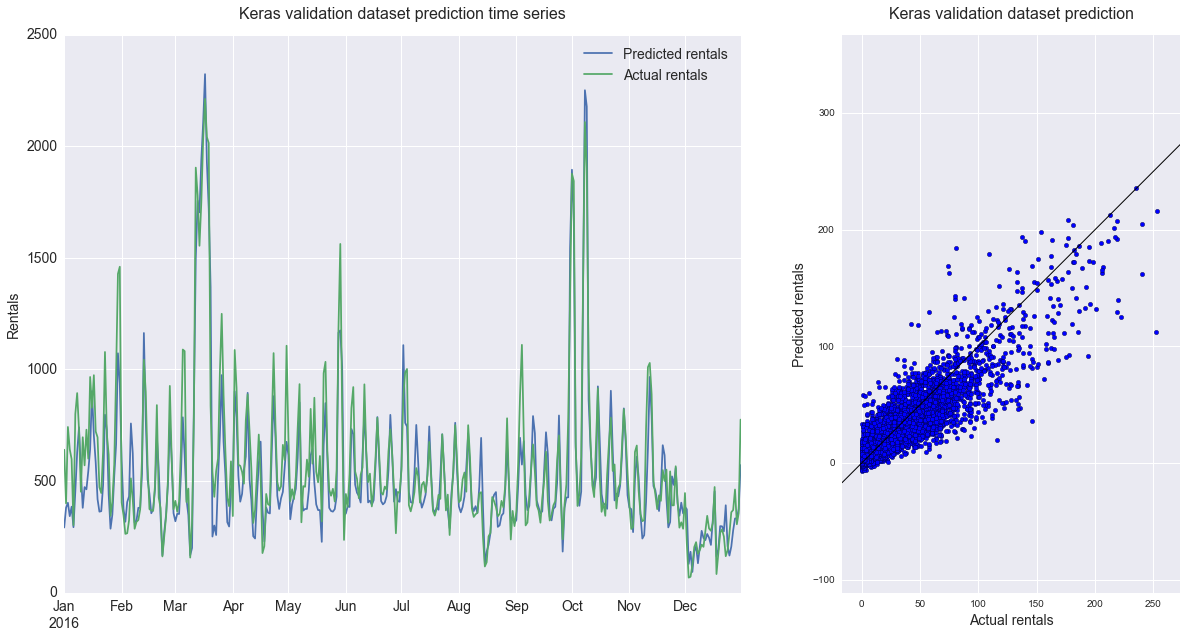

In [78]:
y_val_pred = model.predict(X_val_std).squeeze()
# val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_all_results(result_val_df, 'true', 'pred', 'Keras validation dataset prediction')




In [76]:
y_val_pred.shape

(8784, 1)